# **EDA CII**

#### **I. Import and load data**

In [1]:
# General
from vnstock import Quote
import pandas as pd
import numpy as np
import datetime
import sys
import os

# Statistics
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Visualization
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set_style('dark')
sns.set()

# utils
sys.path.append(os.path.abspath('..'))
from src.utils.get_data import get_stock, get_risk_free

In [ ]:
# Config 
START_DATE = '2007-01-01'
END_DATE = '2025-09-01'
#END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

In [38]:
rf = 0.0

In [4]:
# CII data
df = get_stock('CII', START_DATE, END_DATE)
df.shape

(4668, 8)

#### **II. EDA**

##### 1. Data structure

In [5]:
df.head()

,time,open,high,low,close,volume,return,log_return
1,2007-01-03,8.17,8.33,8.17,8.33,132630,0.012151,0.012077
2,2007-01-04,8.75,8.75,8.75,8.75,84540,0.050420,0.049190
3,2007-01-05,9.17,9.17,9.17,9.17,171100,0.048000,0.046884
4,2007-01-08,9.58,9.58,9.50,9.50,331040,0.035987,0.035355
5,2007-01-09,9.92,9.92,9.50,9.92,407850,0.044211,0.043261


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4668 entries, 1 to 4668
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        4668 non-null   datetime64[ns]
 1   open        4668 non-null   float64       
 2   high        4668 non-null   float64       
 3   low         4668 non-null   float64       
 4   close       4668 non-null   float64       
 5   volume      4668 non-null   int64         
 6   return      4668 non-null   float64       
 7   log_return  4668 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 291.9 KB


In [7]:
df.isna().sum()

time          0
open          0
high          0
low           0
close         0
volume        0
return        0
log_return    0
dtype: int64

##### 2. Price analysis

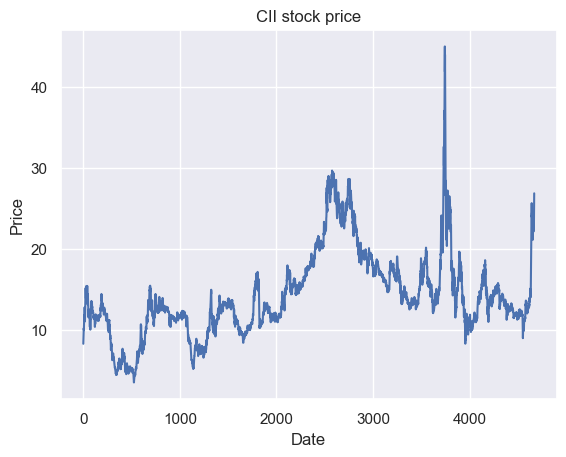

In [8]:
# Plot 
plt.plot(df['close'])
plt.title('CII stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

- Price is much more volatile than FPT, seems seasonal with no clear trend at all.
- There is a sharp price on around 3700th day.

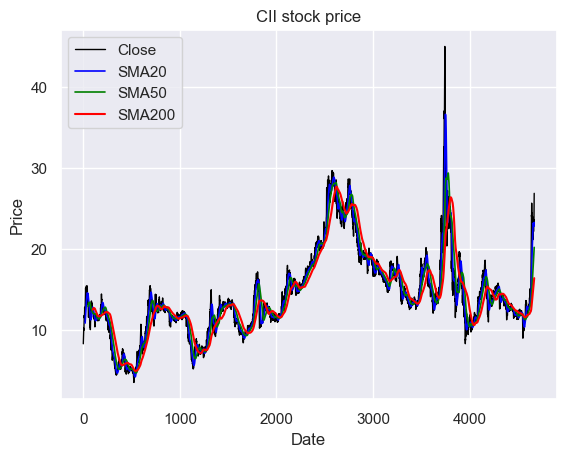

In [9]:
# Overlaying moving average
df['SMA20'] = df['close'].rolling(20).mean()
df['SMA50'] = df['close'].rolling(50).mean()
df['SMA200'] = df['close'].rolling(100).mean()

plt.plot(df['close'], label='Close', color='black', linewidth=1)
plt.plot(df['SMA20'], label='SMA20', color='blue', linewidth=1.2)
plt.plot(df['SMA50'], label='SMA50', color='green', linewidth=1.2)
plt.plot(df['SMA200'], label='SMA200', color='red', linewidth=1.5)

plt.legend()
plt.title('CII stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

- The short term moving average lines (20, 50) hug closely to the price line (black). Meanwhile, the red line is more further away from the black line.  
=> Short fluctuation does not show much variance (short term SMAs still follow up the price line).  
=> In a long period there is a lot of fluctuation (the red line does not follow up the price line causing it deviating from the black line).
- Golden cross \ Death cross is hard to be found since the trend fluctuate frequently.  => Bearish \ Bullish in the long run is not a good strategies.
- For sharp price days, the gap between price with short SMAs become further since the spike occur in an event that not last long then immediately drop back.  
=> May be considered as outlier.

In [10]:
# Stationarity

# ADF test
adf_test = adfuller(df['close'])
print(f'ADF p-value: {adf_test[1]}')

# KPSS test
kpss_test = kpss(df['close'], regression='ct')
print(f'KPSS p-value: {kpss_test[1]}')

ADF p-value: 0.0983557801131636
KPSS p-value: 0.01


The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



- Data is definitely non stationary. As can also be seen in the plot, there is spike with immedate drop back and price tend to be completely above or under the red overall trend line for a period of time.

##### 9. Return analysis

In [11]:
df.describe()[['return', 'log_return']]

,return,log_return
count,4668.000000,4668.000000
mean,0.000584,0.000253
min,-0.070361,-0.072959
25%,-0.012861,-0.012944
50%,0.000000,0.000000
75%,0.013229,0.013143
max,0.070513,0.068138
std,0.025725,0.025709


- Mean: 0.055%, Median: 0.0%, std: 2.57%
- Log return and mean return relatively close to 0 and median, return not skewd.

In [12]:
# Annual return
ann_return = (stats.gmean(1+df['return'])-1)*100*252
print(f'Annual return: {ann_return:.2f}%')

Annual return: 6.38%


In [13]:
# Annual volatility
ann_std = df['return'].std()*np.sqrt(252)*100
print(f'Annual volatility: {ann_std:.2f}%')

Annual volatility: 40.84%


Risky and low expected return.

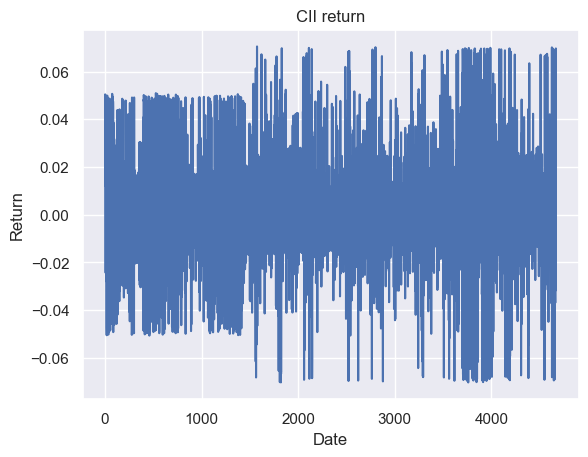

In [14]:
# Plot return
plt.plot(df['return'])
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('CII return')
plt.show()

- First 1400 days has more stable volatility than the later part where volatility mixed with very high and very low variances.

<Axes: >

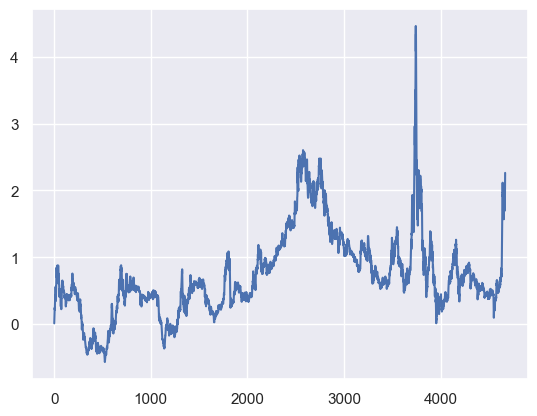

In [15]:
# Cumulative return
cum_return = (1+df['return']).cumprod() - 1
cum_return.plot()

<Axes: xlabel='return', ylabel='Count'>

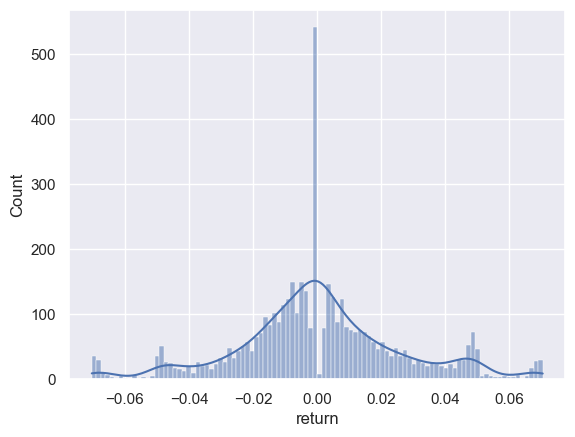

In [16]:
sns.histplot(df['return'], kde=True, bins=100)

No sharp peak, tails are a little bit heavy, a little bit left-skewd.

In [17]:
# Skewness
print(f'Skewness: {df['return'].skew()}')

Skewness: 0.08272237268358175


In [18]:
# Kurtosis
print(f'Kurtosis: {df['return'].kurtosis()}')

Kurtosis: 0.6438803087886105


((array([-3.6179409 , -3.38153934, -3.2511914 , ...,  3.2511914 ,
          3.38153934,  3.6179409 ], shape=(4668,)),
  array([-0.0703606 , -0.07034483, -0.0702403 , ...,  0.07011331,
          0.07019064,  0.07051282], shape=(4668,))),
 (np.float64(0.025437676309219306),
  np.float64(0.0005838596920271412),
  np.float64(0.9882169520689364)))

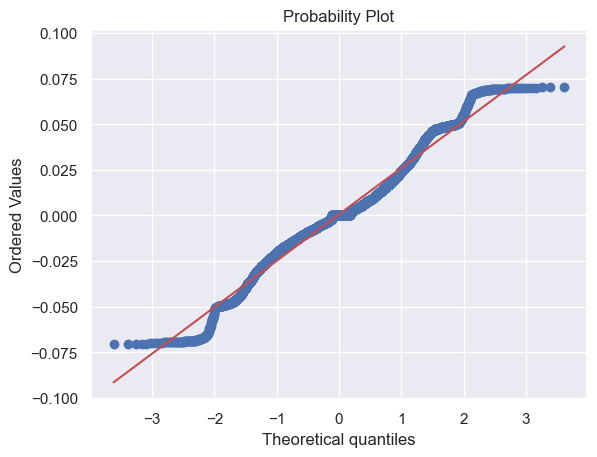

In [19]:
# Q-Q plot
stats.probplot(df['return'], dist='norm', plot=plt)

Data is slightly left-skewed but overall normal.

Even though normal around 0, since the price fluctuate around a price before a significant change which cause rare large return which is more meaningful than the 0 mean. And the data has quite heavy tail or more mass on the extrem value which show the significant in the amount of such values.

In [20]:
# Sharpe ratio
print(f'Sharpe ratio: {(ann_return - rf) / ann_std}')

Sharpe ratio: 0.14735017367028033


In [21]:
# Sortino ratio
sortino_ratio = (ann_return- rf) / (df['return'][df['return'] < 0].std() * np.sqrt(252)*100)
print(f"Sortino ratio: {sortino_ratio:.2f}")

Sortino ratio: 0.23


Small return and high risk causing lower Sharpe ratio => not too efficient return / risk ratios.

In [22]:
# Max drawdown (MDD)
mdd = ((df['close'].cummax() - df['close']) / df['close'].cummax()).max()
print(f'Max drawdown: {mdd*100:.2f}%')

Max drawdown: 81.44%


In [23]:
# ADF
adf_result = adfuller(df['return'])
print(f'ADF p-value: {adf_result[1]}')

print()

# KPSS
kpss_result = kpss(df['return'], regression='c')
print(f'KPSS p-value: {kpss_result[1]}')

kpss_trend = kpss(df['return'], regression='ct')
print(f'KPSS trend p-value: {kpss_trend[1]}')

ADF p-value: 4.6550506590701624e-29

KPSS p-value: 0.1
KPSS trend p-value: 0.1


The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



- ADF: stationary
- KPSS: non-stationary  

=> Unit root stationary but no trend stationary, variance in the later part (after 1400th) shifts alot.  
=> Can still use ARCH/GARCH model (stationary mean + time-varying variance)

##### 4. Autocorrelation test

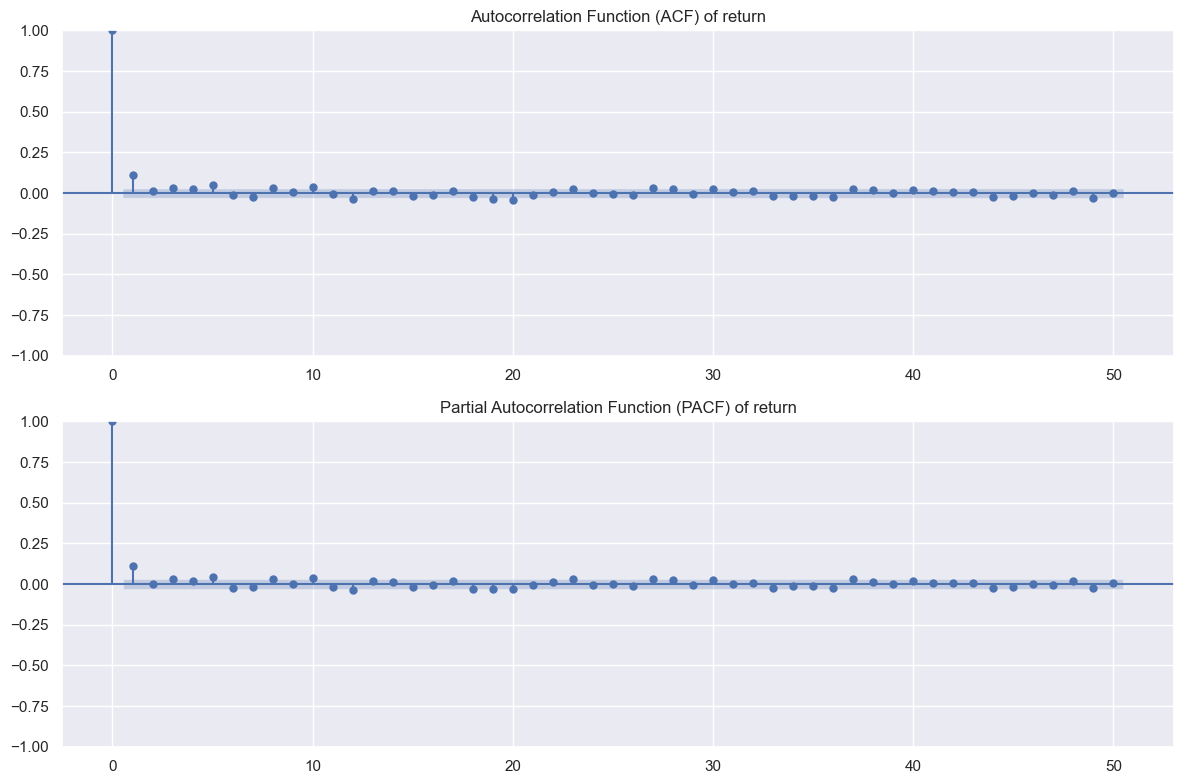

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['return'], lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) of return')

plot_pacf(df['return'], lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) of return')

plt.tight_layout()
plt.show()

- Lag 1: highly positive => Momentum => Tend to have stabel trend before switching direction.
- Lag 5, 10, 23: positive => positive but very tiny correlation.
- Lag 19, lag 44 may show negative correlation but very tiny. => Test on model and eliminate if not significant.

=> Most likely whitenoise, mean dynamic models (AR, ARMA,...) not appropriate.

In [25]:
# Ljung-Box test
lb_result = acorr_ljungbox(df['return'], lags=[1, 5, 10, 20, 23, 30, 19, 44])
print(f"Return:\b {lb_result}")

print()

# Ljung-Box test on squared returns
lb_result = acorr_ljungbox(df['return']**2, lags=[1, 5, 10, 20, 23, 30, 19, 44])
print(f"Return squared:\n {lb_result}")


Return        lb_stat     lb_pvalue
1    58.758146  1.782938e-14
5    79.116675  1.284146e-15
10   93.308024  1.179737e-15
20  121.381076  1.581508e-16
23  126.239346  3.098280e-16
30  137.925100  8.845991e-16
19  112.884121  2.338254e-15
44  157.309319  1.188117e-14

Return squared:
         lb_stat      lb_pvalue
1    499.364524  1.306885e-110
5   1860.486882   0.000000e+00
10  2986.376637   0.000000e+00
20  4763.340516   0.000000e+00
23  5122.272832   0.000000e+00
30  5893.401422   0.000000e+00
19  4614.604572   0.000000e+00
44  6958.959893   0.000000e+00


- Reject null hypothesis but may due to sample size since the ACF bars is very small.

=> Even though some lags show statistically significant, appart from lag 1, most does not provide economical significance.

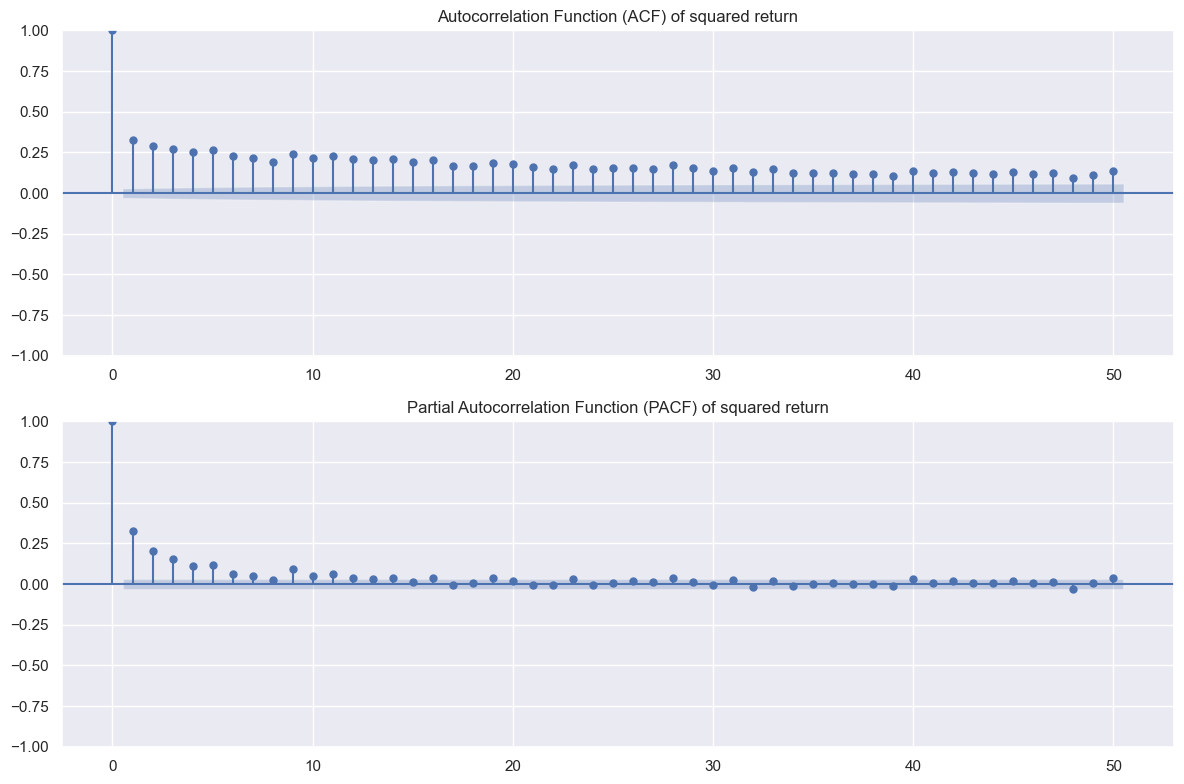

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['return']**2, lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) of squared return')

plot_pacf(df['return']**2, lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) of squared return')

plt.tight_layout()
plt.show()

Squared return:
- High ACF in all lags. 
- High PACF until lag 5, lag 9 also considerable 
=> Variance clustering => ARCH\GARCH.

##### 5. Risk analysis

Value at Risk

In [27]:
# Parametric
mu = df['return'].mean()
sigma = df['return'].std()

confidence = 0.95
z = stats.norm.ppf(1-confidence)

Var_95 = mu + z * sigma
print(f'95% VaR: {Var_95*100:.2f}%')

# Historical Simulation
Var_95_hist = np.percentile(df['return'], (1-confidence)*100)
print(f'95% VaR (historical): {Var_95_hist*100:.2f}%')

95% VaR: -4.17%
95% VaR (historical): -4.58%


Pretty close since distribution is close to normal. Yet the risk is quite high and quite far away from the mean.

In [28]:
# CVaR
CVaR_95 = df['return'][df['return'] <= Var_95_hist].mean()
print(f'95% CVaR: {CVaR_95*100:.2f}%')

95% CVaR: -5.65%


Tail risk anaylysis POT

In [29]:
extreme_losses = df[df['return'] <= Var_95_hist]['return']

print(f"Tail sample size: {len(extreme_losses)}")
print(f"Tail sample mean: {extreme_losses.mean()*100:.2f}%")
print(f"Max loss observed: {extreme_losses.min()*100:.2f}%")

Tail sample size: 235
Tail sample mean: -5.65%
Max loss observed: -7.04%


Max loss is quite the same as FPT's, but VaR and Tail mean all higher upto 1%, which means on average CII is riskier but on the worst historical case it not far from FPT's worst one.

##### 6. Seasonality & Event

In [30]:
# Day-of-week effect
df['time'] = pd.to_datetime(df['time'])
df['day_of_week'] = df['time'].dt.day_name()

day_mean = df.groupby('day_of_week')['return'].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)
day_mean

,mean,count,std
day_of_week,,,
Wednesday,0.002375,940,0.025598
Friday,0.001066,937,0.024993
Thursday,0.000459,943,0.024600
Tuesday,0.000074,935,0.025690
Monday,-0.001104,913,0.027628


In [31]:
# ANOVA
groups = [df.loc[df['day_of_week'] == d, 'return'] for d in df['day_of_week'].unique()]
f_stats, p_values = stats.f_oneway(*groups)
print(f'F-statistic: {f_stats}, p-value: {p_values}')

F-statistic: 2.305019844266328, p-value: 0.055991625025312096


In [32]:
# Post-hoc
turkey = pairwise_tukeyhsd(df['return'], df['day_of_week'])
print(turkey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower  upper  reject
--------------------------------------------------------
  Friday    Monday  -0.0022 0.3646 -0.0054 0.0011  False
  Friday  Thursday  -0.0006 0.9862 -0.0038 0.0026  False
  Friday   Tuesday   -0.001 0.9198 -0.0042 0.0023  False
  Friday Wednesday   0.0013 0.8051 -0.0019 0.0045  False
  Monday  Thursday   0.0016 0.6855 -0.0017 0.0048  False
  Monday   Tuesday   0.0012 0.8622 -0.0021 0.0044  False
  Monday Wednesday   0.0035 0.0296  0.0002 0.0067   True
Thursday   Tuesday  -0.0004 0.9976 -0.0036 0.0029  False
Thursday Wednesday   0.0019 0.4861 -0.0013 0.0052  False
 Tuesday Wednesday   0.0023 0.2973 -0.0009 0.0055  False
--------------------------------------------------------


No significant evidences. Even though the mean gap is relatively large at this scale, the std is also large.

In [33]:
# Month effect
df['month'] = df['time'].dt.month

month_mean = df.groupby('month')['return'].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)
month_mean

,mean,count,std
month,,,
8,0.004652,420,0.026170
12,0.002291,395,0.024400
1,0.001156,366,0.028221
3,0.000908,419,0.025672
2,0.000703,318,0.028335
9,0.000601,378,0.024184
11,0.000530,386,0.025242
7,0.000455,422,0.023430
10,-0.000942,399,0.024600


In [34]:
# Anova
groups_month = [df.loc[df['month'] == m, 'return'] for m in df['month'].unique()]
f_stats, p_values = stats.f_oneway(*groups_month)
print(f'F-statistic: {f_stats}, p-value: {p_values}')

F-statistic: 1.7823614562401264, p-value: 0.05138730462250316


Significant evident to reject null hypothesis.

In [35]:
# Post-hoc
turkey = pairwise_tukeyhsd(df['return'], df['month'])
print(turkey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0005    1.0 -0.0069  0.006  False
     1      3  -0.0002    1.0 -0.0063 0.0058  False
     1      4  -0.0024 0.9847 -0.0086 0.0038  False
     1      5  -0.0024 0.9838 -0.0085 0.0038  False
     1      6  -0.0024 0.9818 -0.0084 0.0037  False
     1      7  -0.0007    1.0 -0.0067 0.0053  False
     1      8   0.0035 0.7584 -0.0025 0.0095  False
     1      9  -0.0006    1.0 -0.0067 0.0056  False
     1     10  -0.0021 0.9935 -0.0082  0.004  False
     1     11  -0.0006    1.0 -0.0068 0.0055  False
     1     12   0.0011    1.0  -0.005 0.0072  False
     2      3   0.0002    1.0  -0.006 0.0065  False
     2      4  -0.0019 0.9982 -0.0083 0.0045  False
     2      5  -0.0019 0.9981 -0.0083 0.0044  False
     2      6  -0.0019 0.9978 -0.0082 0.0044  False
     2      7  -0.0002    1.0 -0.0065  0.006  False
     2      

Only June and August are significant.  
August vs June\May also very close to be significant  

=> May consider these as a variable (is_summer?)

##### 8. Volume analysis

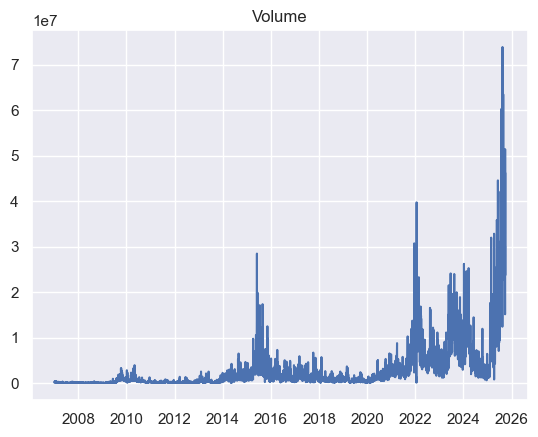

In [36]:
plt.plot(df['time'], df['volume'])
plt.title('Volume')
plt.show()

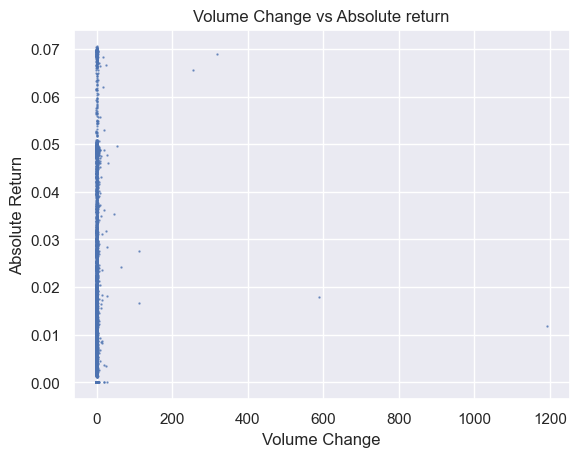

In [37]:
df['VolChange'] = df['volume'].pct_change()
df['AbsReturn'] = df['return'].abs()

plt.scatter(df['VolChange'], df['AbsReturn'], alpha=0.7, s=0.5)
plt.xlabel('Volume Change')
plt.ylabel('Absolute Return')
plt.title('Volume Change vs Absolute return')
plt.show()

Perfectly inelastic.

#### **III. Conclusion**

Overall:  
- Short fluctuation in price is not high but in long-term is quite large.  
- No deterministic trend can be seen in overall trend.
- Return varies around 0 but variance vary in time.
-  Annual return only 5.52% while annual volatility is 40.8% so very risky and low return, has to go with others.
- MDD is very high even up to recent price drop to very low.  
Modeling:
- Close price: hard to predict, to check for price seasonal, may need modeling or exponential smoothing.
- Return does not fully meet stationary assumption, normality is quite close.
- Return seems to be white noise.
- Squared return: has quite high ACF, PACF.
- Summer seasons (4, 5, 6) showed significant different on others.  
=> Feature: is_summer  
=> ARCH/GARCH for volatilty   
=> LSTM on price data for complex relationship.
=> Other models: Treebased, Using audio analysis on return...  